In [2]:
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

2025-04-19 19:57:47.553126: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745107067.607119    5828 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745107067.623361    5828 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745107067.748787    5828 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745107067.748802    5828 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745107067.748804    5828 computation_placer.cc:177] computation placer alr

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
def create_data_generator(data_dir, image_height, image_width, channels):
    data_dir = Path(data_dir)
    categories = sorted([d.name for d in data_dir.iterdir() if d.is_dir()])
    category_to_index = {cat: idx for idx, cat in enumerate(categories)}
    image_label_paths = []
    for cat in categories:
        folder = data_dir / cat
        for ext in ('*.jpg', '*.jpeg', '*.png'):
            for image_path in folder.glob(ext):
                image_label_paths.append((image_path, category_to_index[cat]))
    def generator():
        for image_path, label_index in image_label_paths:
            img_data = tf.io.read_file(str(image_path))
            img = tf.image.decode_image(img_data, channels=channels)
            img.set_shape([None, None, channels])
            img = tf.image.resize(img, [image_height, image_width])
            img = tf.cast(img, tf.float32) / 255.0
            label = tf.one_hot(label_index, depth=len(categories))
            yield img, label
    return generator, len(categories), len(image_label_paths), categories

def create_model(num_classes, image_height, image_width, channels):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 3, activation='relu',
                               input_shape=(image_height, image_width, channels)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax'),
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model.summary()
    return model

In [4]:
IMAGE_HEIGHT = 400
IMAGE_WIDTH = 400
IMAGE_CHANNELS = 3
BATCH_SIZE = 16

In [5]:
data_dir = '../data/sorted_images'

print('TensorFlow version:', tf.__version__)

generator, num_classes, size, categories = create_data_generator(
    data_dir, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)
print(f'Found {size} images belonging to {num_classes} classes: {categories}')

TensorFlow version: 2.19.0
Found 3914 images belonging to 6 classes: ['certification', 'icons', 'logo', 'other', 'people', 'project image']


In [8]:
dataset = tf.data.Dataset.from_generator(
    generator,
    output_signature=(
        tf.TensorSpec(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=tf.float32),
        tf.TensorSpec(shape=(num_classes,), dtype=tf.float32),
    )
)
dataset = dataset.take(int(size*0.5))
dataset = dataset.shuffle(size)

train_size = int(size * 0.8)
train_ds = dataset.take(train_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = dataset.skip(train_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [7]:
model = create_model(num_classes, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)

/home/daniel/Desktop/Coding/thundrmodels/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 398, 398, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 199, 199, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 197, 197, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 98, 98, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 96, 96, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 48, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 294912)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    37,748,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,842,886 (144.36 MB)

 Trainable params: 37,842,886 (144.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model = tf.keras.models.load_model("../models/imagezap.keras")

ValueError: File format not supported: filepath=../models/imagezap. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(../models/imagezap, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).

In [10]:
history = model.fit(train_ds,
            epochs=3,
            validation_data=val_ds)

Epoch 1/3


I0000 00:00:1745080706.378026   16049 service.cc:152] XLA service 0x75ba98106700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745080706.378043   16049 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2025-04-19 12:38:26.398242: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745080706.518881   16049 cuda_dnn.cc:529] Loaded cuDNN version 90300


      2/Unknown 15s 76ms/step - accuracy: 0.1562 - loss: 7.3698

I0000 00:00:1745080712.865428   16049 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    123/Unknown 26s 94ms/step - accuracy: 0.4114 - loss: 1.9048

2025-04-19 12:38:44.372673: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-04-19 12:38:44.372693: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1506402604013763224
2025-04-19 12:38:44.372703: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
/home/daniel/Desktop/Coding/thundrmodels/.venv/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


123/123 ━━━━━━━━━━━━━━━━━━━━ 34s 159ms/step - accuracy: 0.4119 - loss: 1.9004
Epoch 2/3


2025-04-19 12:38:52.366663: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-04-19 12:38:52.366681: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4992221552665278968
2025-04-19 12:38:52.366691: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1506402604013763224


122/123 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6499 - loss: 0.8549

2025-04-19 12:39:09.181419: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4992221552665278968
2025-04-19 12:39:09.181439: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1506402604013763224


123/123 ━━━━━━━━━━━━━━━━━━━━ 25s 139ms/step - accuracy: 0.6503 - loss: 0.8546
Epoch 3/3


2025-04-19 12:39:17.414232: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-04-19 12:39:17.414250: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4992221552665278968
2025-04-19 12:39:17.414261: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1506402604013763224


122/123 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7615 - loss: 0.6276

2025-04-19 12:39:34.493643: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4992221552665278968
2025-04-19 12:39:34.493662: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1506402604013763224


123/123 ━━━━━━━━━━━━━━━━━━━━ 25s 139ms/step - accuracy: 0.7616 - loss: 0.6273


2025-04-19 12:39:42.722612: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 4992221552665278968
2025-04-19 12:39:42.722634: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1506402604013763224


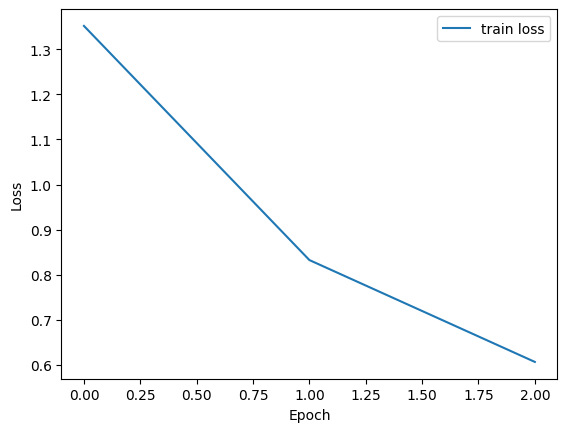

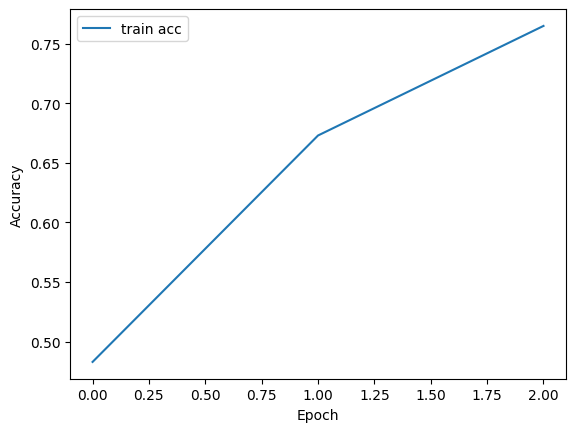

In [11]:
# Plot training & validation loss
plt.plot(history.history["loss"], label="train loss")
# plt.plot(history.history["val_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot training & validation accuracy
plt.plot(history.history["accuracy"], label="train acc")
# plt.plot(history.history["val_accuracy"], label="val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [31]:
with Image.open("../data/test2.png") as img:
    # Ensure image is in RGBA for proper transparency handling
    img = img.convert("RGBA")
    # Create a new 400x400 background with pink color
    bg_color = (255, 39, 255)
    new_img = Image.new("RGB", (400, 400), bg_color)
    
    img.thumbnail((400, 400), Image.LANCZOS)
    # Calculate coordinates to center the image on the background
    left = (400 - img.width) // 2
    top = (400 - img.height) // 2
    # Paste the resized image onto the off-gray background using the image's alpha channel as mask
    new_img.paste(img, (left, top), img)

    new_img.save("../data/test_output.png")

img_data = tf.io.read_file("../data/test_output.png")
img_data = tf.image.decode_image(img_data, channels=IMAGE_CHANNELS)
img_data.set_shape([None, None, IMAGE_CHANNELS])
img_data = tf.image.resize(img_data, [IMAGE_HEIGHT, IMAGE_WIDTH])
img_data = tf.cast(img_data, tf.float32) / 255.0


In [32]:
categories

['certification', 'icons', 'logo', 'other', 'people', 'project image']

In [33]:
model.predict(np.array([img_data]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


array([[1.1839200e-01, 3.9068055e-01, 1.6468991e-01, 3.2602790e-01,
        1.1236082e-05, 1.9837593e-04]], dtype=float32)

In [ ]:
model.save("../models/imagezap")

INFO:tensorflow:Assets written to: ../models/imagezap/assets


INFO:tensorflow:Assets written to: ../models/imagezap/assets
